# Causal Data Analysis

We have seen how to characterize the relationship between two or more variables with correlation and linear regression. We also said that **correlation is not causation**, meaning that, if we observe a correlation between two variables, that does not necessarily imply a cause-effect relationship between them. However, in many cases, it is still useful (or better required!) to establish a cause-effect relationship (or lack thereof) between two variables. Consider the following examples:

* We assess that **a given disease is more frequent among smokers**. Is this just a correlation or is there a cause-effect relationship? If a smoker stops smoking, will their risk to get the disease be reduced?
* **We develop a new drug** and assess that people taking this drug are less likely to get disease X. Is this just a correlation or is there a cause-effect relationship? This is important, as people should take the drug only if benefits are clear.
* **A large company founds that product sites located in the geographical areas close to the sea are more productive than the others**. Is this just a correlation or is it a cause-effect relationship? Shall we move all sites closer to the sea?

Luckily, the field of **causal analysis** has, over the years, developed a set of tools which allow to answer those questions.

The goal of this lecture is to provide a primer of causal analysis, introducing the main concepts and discussing some techniques which can be applied in some simple cases.

## Sleep vs Exam Performance
We will consider a simple example which will guide us through the understanding of the main concepts of causal analysis. The data is made up and showing somewhat extreme correlations, but it should serve the purpose of illustrating the main concepts.

We want to study the relationship between sleep and exam performance (in a $0-100$ scale), so we asked $50$ students to tell us about their sleeping habits (in particular, we asked if they sleep, in average, 8 hours of more, the recommended number of hours for their age). We put these numbers together with the average exam performance of the students, obtaining the following data:

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Simulate data with a confounder (sleep duration)
np.random.seed(42)
num = 50
study_time = np.random.normal(6, 2, num)  # Mean study time of 5 hours with a standard deviation of 2 hours
sleep_duration = 14 - study_time*np.random.normal(1, 0.2, num) + np.random.normal(0, 1, num)  # Mean sleep duration of 7 hours with a standard deviation of 1.5 hours
exam_performance = 40 + 5 * study_time + np.random.normal(0, 10, num)  # Linear relationship with noise
exam_performance[exam_performance>100] = 100

# Create a DataFrame
students_all = pd.DataFrame({'Average Study Time': study_time, 'Average Sleep Duration': sleep_duration, 'Average Exam Performance': exam_performance})

students_all['Sleep 8 Hours or More'] = students_all['Average Sleep Duration']>=8
students_sleep = students_all.drop('Average Study Time',axis=1)
students_sleep = students_sleep.drop('Average Sleep Duration', axis=1)
students_sleep


,Average Exam Performance,Sleep 8 Hours or More
0,77.472070,False
1,72.081839,True
2,69.676638,False
3,87.552836,False
4,70.589191,False
5,60.515116,False
6,100.000000,True
7,82.412677,False
8,53.392221,True
9,81.991137,False


We want to understand if sleep has an effect on exam performance. Let us show some boxplots:

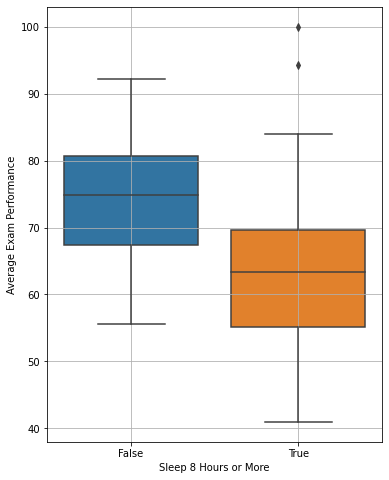

In [171]:
import seaborn as sns
plt.figure(figsize=(6,8))
sns.boxplot(x='Sleep 8 Hours or More', y='Average Exam Performance', data=students_sleep)
plt.grid()
plt.show()

We got a surprising picture! Sleeping $8$ hours or more, actually affects negatively the average exam performance! To check if everything is fine, we can add some "notch" to the boxplots. The notch will highlight the confidence intervals for the estimation of the median value:

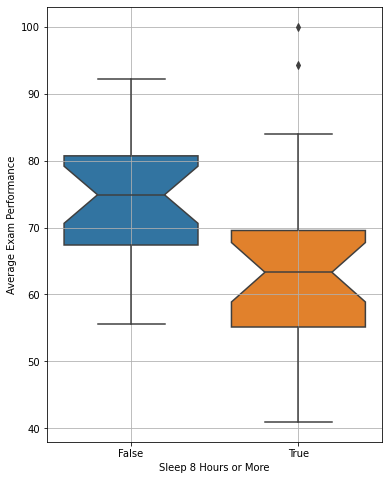

In [172]:
import seaborn as sns
plt.figure(figsize=(6,8))
sns.boxplot(x='Sleep 8 Hours or More', y='Average Exam Performance', data=students_sleep, notch=True)
plt.grid()
plt.show()

Since the notches do not intersect, there is no overlap between the confidence interval for a C.L. of $95$, hence it is very unlikely that the two median values are very close to each other. The difference seem to be statistically relevant. If we want to be very sure we can **compute a two-sample t-Test** to ensure that the mean values of the two samples actually are distinct. The null hypothesis will be that the two samples have the same mean. If we reject this hypothesis, then the two means are distinct. We obtain the following test statistic and p-value:

In [173]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(students_sleep[students_sleep['Sleep 8 Hours or More']]['Average Exam Performance'], students_sleep[~students_sleep['Sleep 8 Hours or More']]['Average Exam Performance'])

print(f"Test statistic: {t_stat}")
print(f"P-value: {p_value}")


Test statistic: -2.5330249947772807
P-value: 0.014630790631265746


Also in this case, the difference seems to be statistically significant.

## Measuring Causation - Potential Outcomes (Counterfactuals)
We now start formulating hypotheses and theories: it looks counter-intuitive, but this is what the data is telling us. Isn't it? It might be that sleeping too much make you less reactive in the morning, so you cannot properly focus and this make you a worse student. 

If this is true, than we could "prescribe" students to sleep less than $8$ hours to obtain gains in performance. But we also know that... **correlation is not (necessarily) causation!**. We are seeing a correlation here - is it also causation? Of course, we want to be able to tell our students whether to sleep less or not!

To be able to truly assess a causal relationship between the two variables, ideally, we would like to **take the same student and ask them to sleep more than $8$ hours for one year, than less than $8$ hours for another years, then compare performance**. This is of course unethical and impractical. And even if we could do so, between the two years, different other factors may change, so the two values will never be fully comparable.

We will now **enter the real of potential outcomes**. In practice, we as ourselves questions such as **"what if this student slept less than $8$ hours?"**. Let's see some notation first. We will define two variables:

* $T_i$: a "treatment" value indicating whether the observation $i$ (student $i$) took the treatment (i.e., slept more than $8$ hours) or not. Here we use the standard terminology of causal inference which uses the word "treatment" as in health-related sciences. We will assume this variable to be binary: $T_i=1$ means "took the treatment", while $T_i=0$ means "didn't take the treatment".
* $Y_i$: the "outcome" of observation $i$. In our case, this is the average performance of student $i$.

If for a unit $i$, the treatment value is $T_i=t$, we will denote the related observation $Y_i$ as $Y_i(t)$. We note that, for a given unit $i$, we will **either observe $Y_i(0)$ or $Y_i(1)$, but never both!**.

Nevertheless, we will introduce the concept of **potential outcome** as the **value we would observe if we were able to intervene on the treatment variable $T_i$ and change it**. If for a unit $i$ we have $T_i=0$, we will directly observe the outcome $Y_i(0)$, but we will also **theoretically define** the potential outcome $Y_i(1)$. This **is not real and cannot be observed** but it will serve as a useful theoretical concept.

Potential outcomes are also known as **counterfactuals** because they answer to the question "what if...".

If we had potential outcomes, for each unit $i$ we could compute the **individual treatment effect** (the effect of taking the treatment) as:

$$Y_i(1) - Y_i(0)$$

This is the effect of sleeping less than $8$ hours. If we average this over the distribution of observations, we obtain the **average treatment effect**:

$$ATE = E[Y(1) - Y(0)]$$

This value will tell us **how the exam performance varies in average if the same subjects sleep less or more than $8$ hours**. As such, it would indicate **the causal effect of sleep on examination performance**.

Alternatively, we can compute the **average treatment effect on the treated**:

$$ATT = E[Y(1) - Y(0)|T=1]$$

This simply restrict the computation to the treated subjects, and **also establishes a causal effect**.

## The Bias Arising from Correlation

Without potential outcomes, we cannot compute the $ATE$ or $ATT$ scores. Indeed, we have **two distinct groups**, the **treated** (i.e., those observations $i$ such that $T_i=1$) and the **untreated**, also known as **control group** (i.e., those observations $i$ such that $T_i=0$).

We could think to replace that calculation with the only data we can observe:

$$E[Y(1)|T=1] - E[Y(0)|T=0]$$

This is what **a correlation can measure**: the change in average value of $Y$ in two distinct groups with different characteristics.

Note that there are no potential outcome in the expression above as we directly observe $Y_i(1)$ when $T_i=1$ and we directly observe $Y_i(0)$ when $T_i=0$. However, the expression above is now **comparing different groups**. Indeed, the subjects who took the treatment are different from the ones who did not take the treatment, and we do not know if their exam performance scores are really comparable. **Imagine that, for some reason, students in group 0 are, by chance, better students, then the difference we measure is going to be biased and will not reveal a cause-effect relationship**.

We can show this in formulas. Let's add and subtract the counterfactual term $E[Y(0)|T=1]$ to the expression above:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = E[Y(1)|T=1] - E[Y(0)|T=0] - E[Y(0)|T=1] + E[Y(0)|T=1]$$

We note that:

$$ATT = E[Y(1) - Y(0)|T=1] = E[Y(1)|T=1] - E[Y(0)|T=1]$$

Hence, we can see the expression above as follows:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = E[Y(1)|T=1] - E[Y(0)|T=1] + E[Y(0)|T=1] - E[Y(0)|T=0] = ATT + E[Y(0)|T=1] - E[Y(0)|T=0]$$

We will call the last term the bias:

$$BIAS = E[Y(0)|T=1] - E[Y(0)|T=0]$$

So the whole expression can be seen as:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = ATT + BIAS$$

which shows that the effect given by the correlation (left term) is **biased**. Note that the bias cannot be computed (it contains a counterfactual term), but we can interpret it as follows:

> The bias measures how the treated ($T=1$) and control ($T=0$) groups would differ if no one had taken the treatment.

In practice: 
* If the groups are similar to each other (e.g., treated and control group are mixed students with similar abilities), then the bias will be small or zero. Indeed, in this case, the difference in exam performance among the two groups if everybody sleeps less than $8$ hours should be same, as students have similar abilities.
* If the groups are dissimilar (e.g., control students are all better students), then the bias will be different from zero. Indeed, if students in the control group are "better students", if all sleep less than $8$ hours, students in the control group will perform better in average, but this has nothing to do with sleeping less or more or with cause-effect relationships among the observed variables.

Note that, given the observations above, we now know **when association allows to establish a cause-effect mechanism**. This happens when the bias is zero:

$$BIAS = E[Y(0)|T=1] - E[Y(0)|T=0] = 0$$

That is to say, when the difference between treated and untreated is zero (or at least very small).

Given this intuition, we now try to estimate the students' abilities by asking how many hours they study per day. We get the following data:

In [177]:
students_all.drop('Average Sleep Duration', axis=1)

,Average Study Time,Average Exam Performance,Sleep 8 Hours or More
0,6.993428,77.472070,False
1,5.723471,72.081839,True
2,7.295377,69.676638,False
3,9.046060,87.552836,False
4,5.531693,70.589191,False
5,5.531726,60.515116,False
6,9.158426,100.000000,True
7,7.534869,82.412677,False
8,5.061051,53.392221,True
9,7.085120,81.991137,False


**We cannot measure bias from this data because we do not have access to counterfactual observations**, but we, now that we have access to a proxy for students' abilities, we ca try to see if, in the two groups, abilities are equally distributed. Let's see this with a scatterplot:

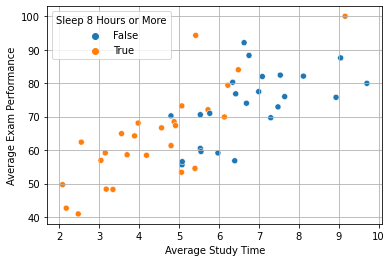

In [178]:
sns.scatterplot(x='Average Study Time', y='Average Exam Performance', data=students_all, hue='Sleep 8 Hours or More')
plt.grid()
plt.show()

From the picture above, we see that students' skills are not equally distributed in the two groups. This is not enough to say that the bias is different from zero, as we are not observing counterfactuals, but we now see that the difference in outcomes could be due to two different causes:
* Sleeping less than $8$ hours improves exam performance.
* Some of the difference may be due to the fact that students sleeping less than $8$ hours, incidentally, study more. This might be a sampling problem (we were lucky/unlucky) or an experiment design problem: students who sleep less have more time to study, so they have higher performance. If this is the case, it is not meaningful to look at hours of sleep to establish a cause-effect relationship.

Now that we have an intuition into what may make correlation be not indicative of causation, let's see how to reduce bias to establish cause-effect relationships.

## Randomized Experiments

## Graphical Causal Models

## Linear Regression for Causal Analysis